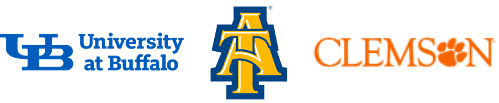

# Lab 1: Cyberbullying Detection Using AI

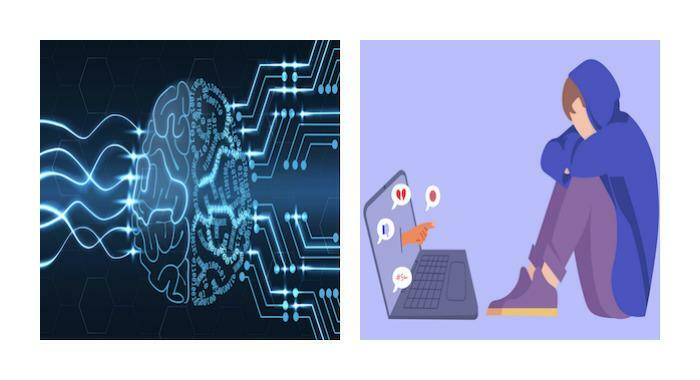

In this lab, we will learn how AI can be developed to detect cyberbullying. We will use a publicly available dataset of cyberbullying texts, and train an AI model on this dataset to automatically detect cyberbullying text. You will learn:

1. AI development process
2. Train and test your own AI for cyberbullying detection
3. Run AI on your own samples
4. Hypterpaprameter tuning to improve model performance

First, we need to download softwares used in the lab. Just hit the 'play' button run the code below.

### Preliminaries

In [ ]:
!git clone https://github.com/nishantvishwamitra/CyberbullyingLab1.git

Cloning into 'CyberbullyingLab1'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 25 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.


Next, we install Pytorch, a framework for training and deploying AI technologies.

In [ ]:
!pip install conda
!conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 299 kB 5.6 MB/s 
     |████████████████████████████████| 66 kB 5.8 MB/s 
     |████████████████████████████████| 109 kB 70.0 MB/s 
     |████████████████████████████████| 500 kB 57.4 MB/s 
  Created wheel for conda: filename=conda-4.3.16-py3-none-any.whl size=336960 sha256=5837606aeb05dad6fd0b8b10ffa2c0f95738451ad91354bd58f16e8bd34b3ce4
  Stored in directory: /root/.cache/pip/wheels/66/ec/2c/cce33d7a071720882d948fd3364d3ff5562bac9e5638768d41
  Created wheel for pycosat: filename=pycosat-0.6.3-cp37-cp37m-linux_x86_64.whl size=143855 sha256=64d8287a966bf88d18ee2bf290636f1730bc21cddac062a1018987870abbb018
  Stored in directory: /root/.cache/pip/wheels/c8/29/0e/a226b7c5a4f24e246f25201c0b1fbf6fb8f19f9cce89b02c36
Successfully built conda pycosat
ERROR: The install method you used for conda--probably either `pip install conda`
or `easy_install conda`--is n

In [ ]:
!pip install torchtext==0.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.0 MB 7.3 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:40tcmalloc: large alloc 1147494400 bytes == 0x3a300000 @  0x7f74db131615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 881.9 MB 20 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does no

Let's import all our softwares dependencies in our iPython notebook

In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234
import pandas as pd
import numpy as np
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext

import nltk
import random
from sklearn.metrics import classification_report
import spacy
from CyberbullyingLab1.models import LSTM
from tqdm import tqdm

### Data Preprocessing

While training AI, datasets are divided into three parts: training dataset, testing dataset and validation dataset. 
- Training set: feed the AI, so the AI can keep learning cyberbullying and non-cyberbullying knowledge. 
- Validation set:  can help the AI know whether its predictions are getting better or worse. 
- Test set: is to evaluate the AI’s performance. 

They are different datasets, there’s no overlap among them.
Let's create these three parts for our dataset.

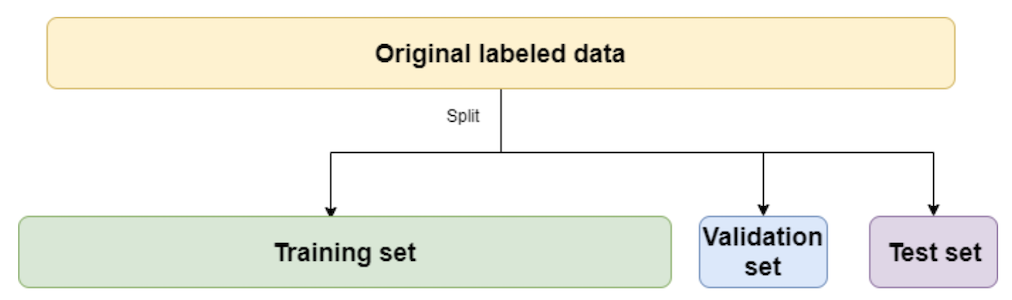

In [ ]:
main_df = pd.read_csv('CyberbullyingLab1/formspring_dataset.csv', sep = '\t')

# Let's see how many smaples we have
print('Total number of samples:', main_df.shape)
main_df = main_df.sample(n = main_df.shape[0])
main_df = main_df[['text', 'label']]

# Let's take a look at a few samples from our dataset
print(main_df.head())

# Let's take a look at the cyberbullying labels
#print(main_df.label.value_counts())

# let's divide the dataset into non-cyberbullying and cyberbullying samples
o_class = main_df.loc[main_df.label == 0, :]
l_class = main_df.loc[main_df.label == 1, :]

# let's create train, val and test splits
train_val = main_df.iloc[:int(main_df.shape[0] * .80)]
test = main_df.iloc[int(main_df.shape[0] * .80):]
train = train_val.iloc[:int(train_val.shape[0] * .80)]
val = train_val.iloc[int(train_val.shape[0] * .80):]

#print(train.shape, val.shape, test.shape)

print('\nTraining set:\n', train.label.value_counts())
print('\nValidation set:\n', val.label.value_counts())
print('\nTest set:\n', test.label.value_counts())

train.to_csv("CyberbullyingLab1/dataset/train.csv", index = False)
test.to_csv("CyberbullyingLab1/dataset/test.csv", index = False)
val.to_csv("CyberbullyingLab1/dataset/valid.csv", index = False)


The first step in natural language processing for AI is tokenization. In this process, we split the text into 'tokens', that are then given unique numbers that are understood by a machine. Take a look at the example below.

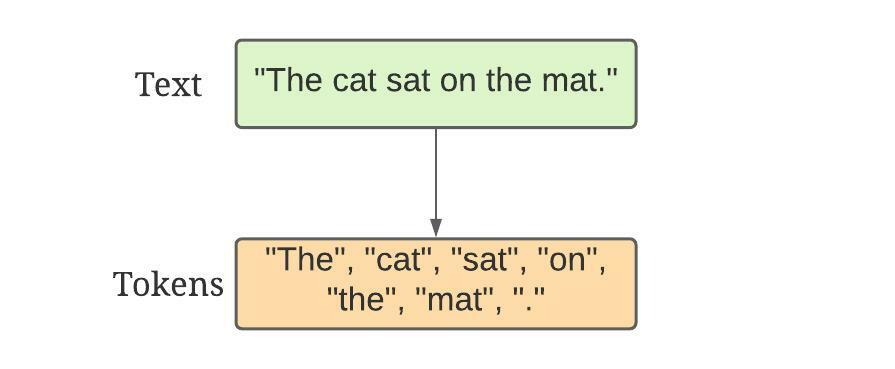

In [ ]:
# Let's use a tokenizer. This is the first step in NLP
spacy_en = spacy.load('en_core_web_sm')

Let's see what tokenization does to the text below. 

In [ ]:
text = spacy_en("the cat sat on the mat.")
for token in text:
  print(token.text)

- - - -
**<font color='red'>Task 1:</font>
Add code below to preprocess the following cyberbullying text, and include the generated tokens in your report:**<br>
“Harlem shake is just an excuse to go full retard for 30 seconds”.
- - - -

In [ ]:
# TODO: Task1
text = spacy_en("Harlem shake is just an excuse to go full retard for 30 seconds")
for token in text:
  print(token.text)

We will use a GPU to train our AI if it is available.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Load the train, validation and test datasets that we prepared.

In [ ]:
# Loading train, test and validation data 
TEXT = data.Field(sequential = True, tokenize = 'spacy')
LABEL = data.LabelField(dtype = torch.long, sequential = False)
train_data, valid_data, test_data = data.TabularDataset.splits(
  path = "CyberbullyingLab1/dataset/", train = "train.csv",
  validation = "valid.csv", test = "test.csv", format = "csv", skip_header = True,
  fields=[('Text', TEXT), ('Label', LABEL)]
)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of valid examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Let's build the vocabulary of our cyberbullying dataset. We first need some pretrained embeddings. Let's download them. The figure shows how embeddings look like in higher dimensional space.

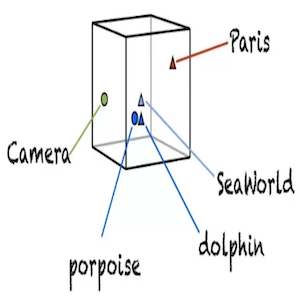

In [ ]:
# download the 100 dimensional embeddings
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!wget https://github.com/cuadvancelab/materials/blob/main/lab1/glove.6B.100d.txt?raw=true

In [ ]:
TEXT.build_vocab(train_data, vectors = torchtext.vocab.Vectors('glove.6B.100d.txt?raw=true'), max_size = 20000, min_freq = 10)
LABEL.build_vocab(train_data)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

We need iterators to step through our dataset. 

In [ ]:
BATCH_SIZE = 20
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
  (train_data, valid_data, test_data), sort_key=lambda x: len(x.Text),
  batch_size=BATCH_SIZE,
  device=device)

Let's define some **hyperparameters** for our AI model.

In [ ]:
# Lets define some hyperparameters
# you can modify the hidden dimension (HIDDEN_DIM) and traning epochs (N_EPOCHS)
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 374
OUTPUT_DIM = 2
N_EPOCHS = 10

Let's instantiate our AI model.

### AI Model Definition

In [ ]:
model = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model

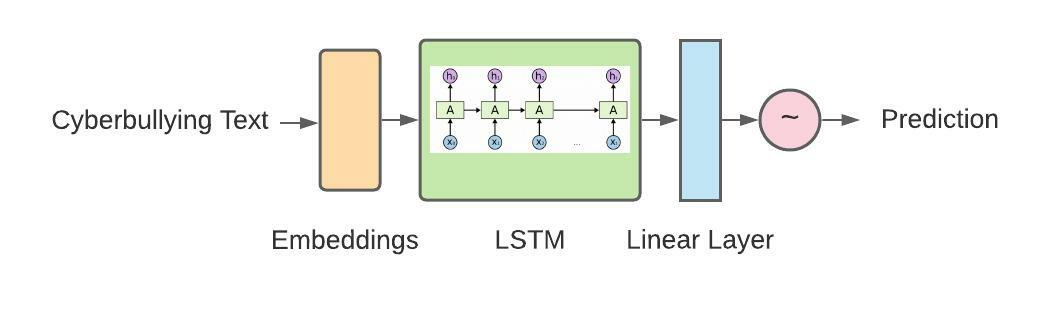

We will use the pretrained embeddings that we downlaoded in our model.

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data = pretrained_embeddings.to(device)

Let's define an optimizer and a loss function for training our AI

In [ ]:
class_weights = torch.tensor([1.0, 14.0]).to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights)

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# @title define the training and testing procedures
def binary_accuracy(preds, y):
  preds, ind= torch.max(F.softmax(preds, dim=-1), 1)
  correct = (ind == y).float()
  acc = correct.sum()/float(len(correct))
  return acc

# Lets define our training steps
def train(model, iterator, optimizer, criterion):

  epoch_loss = 0
  epoch_acc = 0

  model.train()
  for batch in tqdm(iterator):

    optimizer.zero_grad()

    predictions = model(batch.Text).squeeze(0)
    loss = criterion(predictions, batch.Label)
    acc = binary_accuracy(predictions, batch.Label)

    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):

  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  with torch.no_grad():
    for batch in tqdm(iterator):

      predictions = model(batch.Text).squeeze(0)

      loss = criterion(predictions, batch.Label)

      acc = binary_accuracy(predictions, batch.Label)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)


Let's begin training our AI model

### Training Process
- Accuracy = $\frac{correct \ prediciton}{all \ prediciton}$

- Training loss: The training loss is a metric used to assess how a machine learning model fits the training data. That is to say, it assesses the error of the model on the training set.
- Validation loss: On the contrary, validation loss is a metric used to assess the performance of a machine learning model on the validation set.

In [ ]:
for epoch in range(N_EPOCHS):

  train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

  print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')


- - - -
**<font color='red'>Task 2:</font>
What is the final training accuracy that your model achieves?**<br>
- - - -

In [ ]:
#TODO: complete the code below
print(f'Train Acc: {train_acc *100:.2f}%')

Now that our AI is trained, we can use it to detect cyberbullying in user inputted text. In the cell below, try changing the samples to your own cyberbullyign text and see if our AI is able to detect your inputs as cyberbullying. Note:
* 0 indicates non-cyberbullying
* 1 indicates cyberbullying

### Model Evaluation

- - - -
**<font color='red'>Task 3:</font>
Let's review the previous code then finish the next code cell**<br>
- - - -

In [ ]:
#TODO: complete the code below
test_loss, test_acc = evaluate(model, test_iterator, criterion) 
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')

### Deployment

In [ ]:
# @title output function
def predict_cb(sentence):
  tokenized = [tok for tok in sentence.split()]
  indexed = [TEXT.vocab.stoi[t] for t in tokenized]
  tensor = torch.LongTensor(indexed).to(device)

  tensor = tensor.unsqueeze(1)
  prediction = model(tensor)
  preds, ind= torch.max(F.softmax(prediction.squeeze(0), dim=-1), 1)
  if ind.item() == 1:
    return preds, ind, 'Cyberbullying detected.'
  else:
    return preds, ind, 'Cyberbullying not detected.'


In [ ]:
# Change the text below to your own cyberbullying text. Play around with your AI!
text = 'I hate you, you are not my friend anymore'
ret = predict_cb(text)
print(ret[2], f'Confidence: {ret[0].item() * 100:.2f}%')

text = 'I like you my friend'
ret = predict_cb(text)
print(ret[2], f'Confidence: {ret[0].item() * 100:.2f}%')

text = 'hello world'
ret = predict_cb(text)
print(ret[2], f'Confidence: {ret[0].item() * 100:.2f}%')

In [ ]:
#@title Input your own sentence to check the prediction.

My_Sentence = 'we are in the lab1' #@param {type:"string"}

ret = predict_cb(My_Sentence)
print("The Model Prediciton is:")
print()
print(ret[2], f'Confidence: {ret[0].item() * 100:.2f}%')

- - - -
**<font color='red'>Task 4:</font>
Use the samples in [this file](https://raw.githubusercontent.com/cuadvancelab/materials/main/lab1/samples.txt) and your model to detect the cyberbullying samples**<br>
- - - -

### Hyperparameter Tuning

- - - -
**<font color='red'>Task 5-10:</font>
Follow the steps in the manual and finish the tasks under Section 3.3.**<br>
**Please jump to [``hyperparameter_tuning lab``](https://colab.research.google.com/github/cuadvancelab/cuadvancelab.github.io/blob/main/instructions/lab1/computer-science/lab1_hyperparameter_tuning.ipynb)**
- - - -